## Investigating How Data Scientists Answered the Stack Overflow Survey

### Background
I am investigating the 2017 Stack Overflow survey results. A brief description of the survey and the relevant files can be found on [Kaggle](https://www.kaggle.com/stackoverflow/so-survey-2017).

### Questions
Since I am taking the Data Science Nanodegree program from Udacity, I am interested in how data scientists answered the questions in this survey.  The questions I will explore are:
1. How does the mean salary for a data scientist compare to other developer types?
2. How does the mean job satisfaction for a data scientist compare to other developer types?
3. What types of education do data scientists recommend?

### Data Gathering

In [180]:
# Import packages and read in data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Assessment & Cleaning

In [2]:
# Look at some basic descriptive statistics...
display(df.describe())
display(df.shape)

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


(19102, 154)

There are 19,102 rows in the dataset, with each corresponding to a single respondent.  Of the 154 columns, however, there are only 6 columns that have numerical data, which means that most of the columns have categorical responses, including the column that I am interested in exploring first: 'DeveloperType'.

In [3]:
# Look at the first 10 rows of DeveloperType:
df['DeveloperType'].head(10)

0                                                  NaN
1                                                  NaN
2                                                Other
3                                                  NaN
4    Mobile developer; Graphics programming; Deskto...
5                                                  NaN
6                                                  NaN
7                                        Web developer
8                      Web developer; Mobile developer
9     Mobile developer; Desktop applications developer
Name: DeveloperType, dtype: object

Not every respondent provided a developer type, meaning that my sample size will be less than the 19,102 in the dataset.  I also see some respondents provided multiple answers, separated by semicolons, which need to be parsed out.

In [4]:
# Create a function to identify unique responses in DeveloperType
def unique_responses(df_column):
    '''
    Identifies the unique responses in a column of the Stack Overflow dataset
    
    df_column: pandas Series, the column from the pandas Dataframe to parse
    
    returns response_set, a set of the unique responses
    '''
    # Initialize the set
    response_set = set()
    
    # Loop through the column
    for response in df_column:
        # Split the response by semicolon and a space (; ) into multiple developer types
        dev_types = str(response).split('; ')
        # For each developer type in the response, add it to the set of responses
        for dev_type in dev_types:
            response_set.add(dev_type)

    return response_set

In [5]:
# View unique responses in DeveloperType
developer_responses = unique_responses(df['DeveloperType'])
developer_responses

{'Data scientist',
 'Database administrator',
 'Desktop applications developer',
 'DevOps specialist',
 'Developer with a statistics or mathematics background',
 'Embedded applications/devices developer',
 'Graphic designer',
 'Graphics programming',
 'Machine learning specialist',
 'Mobile developer',
 'Other',
 'Quality assurance engineer',
 'Systems administrator',
 'Web developer',
 'nan'}

There are 15 different unique responses to the 'DeveloperType' question, including 'Other' and 'nan' (meaning the respondent didn't answer this question).  Of the 13 possible Developer types listed, 'Data scientist' and 'Machine learning specialist' are the only two that I would consider to be in the data science realm.  I am curious how these two types compare to the rest of the types listed.  But first, I want to know how many respondents fall under each developer type.

In [6]:
# Create a dictionary of the number of responses for each DeveloperType

# Initialize a dictionary for counting
response_dict = dict.fromkeys(developer_responses,0)
# Loop through each row of the dataframe
for response in df['DeveloperType']:
    # For each developer type in the response, increment the dictionary count by 1
    for dev_type in str(response).split('; '):
        response_dict[dev_type] += 1

response_dict

{'Embedded applications/devices developer': 1174,
 'Quality assurance engineer': 429,
 'Data scientist': 1077,
 'Systems administrator': 1479,
 'Web developer': 10086,
 'DevOps specialist': 1505,
 'Machine learning specialist': 488,
 'nan': 5330,
 'Mobile developer': 2905,
 'Other': 996,
 'Graphics programming': 584,
 'Database administrator': 1827,
 'Desktop applications developer': 3869,
 'Graphic designer': 439,
 'Developer with a statistics or mathematics background': 1479}

In [7]:
# Visualize the response dictionary in a sorted dataframe
response_df = pd.DataFrame.from_dict(response_dict,orient='index',columns=['Count'])
response_df.sort_values(by='Count',ascending=False)

,Count
Web developer,10086
nan,5330
Desktop applications developer,3869
Mobile developer,2905
Database administrator,1827
DevOps specialist,1505
Systems administrator,1479
Developer with a statistics or mathematics background,1479
Embedded applications/devices developer,1174
Data scientist,1077


In [8]:
# Since the respondents that did not answer this question do not provide any information to help answer my questions,
# I will drop that response from my dataframe
response_df.drop(index='nan',inplace=True)

In [9]:
# Add a column to the dataframe to reflect frequency of respondents by developer type
# NOTE: This is the number of people (respondents) who included each developer type in their response
num_respondents = 19102-5330 # Total number of respondents minus 'nan's
response_df['Respondent_Freq'] = response_df['Count']/num_respondents

In [10]:
# Create a sorted dataframe for easier plotting
response_df_sorted = response_df.sort_values(by='Count',ascending=False)

# Visualize
response_df_sorted

,Count,Respondent_Freq
Web developer,10086,0.732409
Desktop applications developer,3869,0.280953
Mobile developer,2905,0.210951
Database administrator,1827,0.132670
DevOps specialist,1505,0.109288
Systems administrator,1479,0.107400
Developer with a statistics or mathematics background,1479,0.107400
Embedded applications/devices developer,1174,0.085252
Data scientist,1077,0.078208
Other,996,0.072326


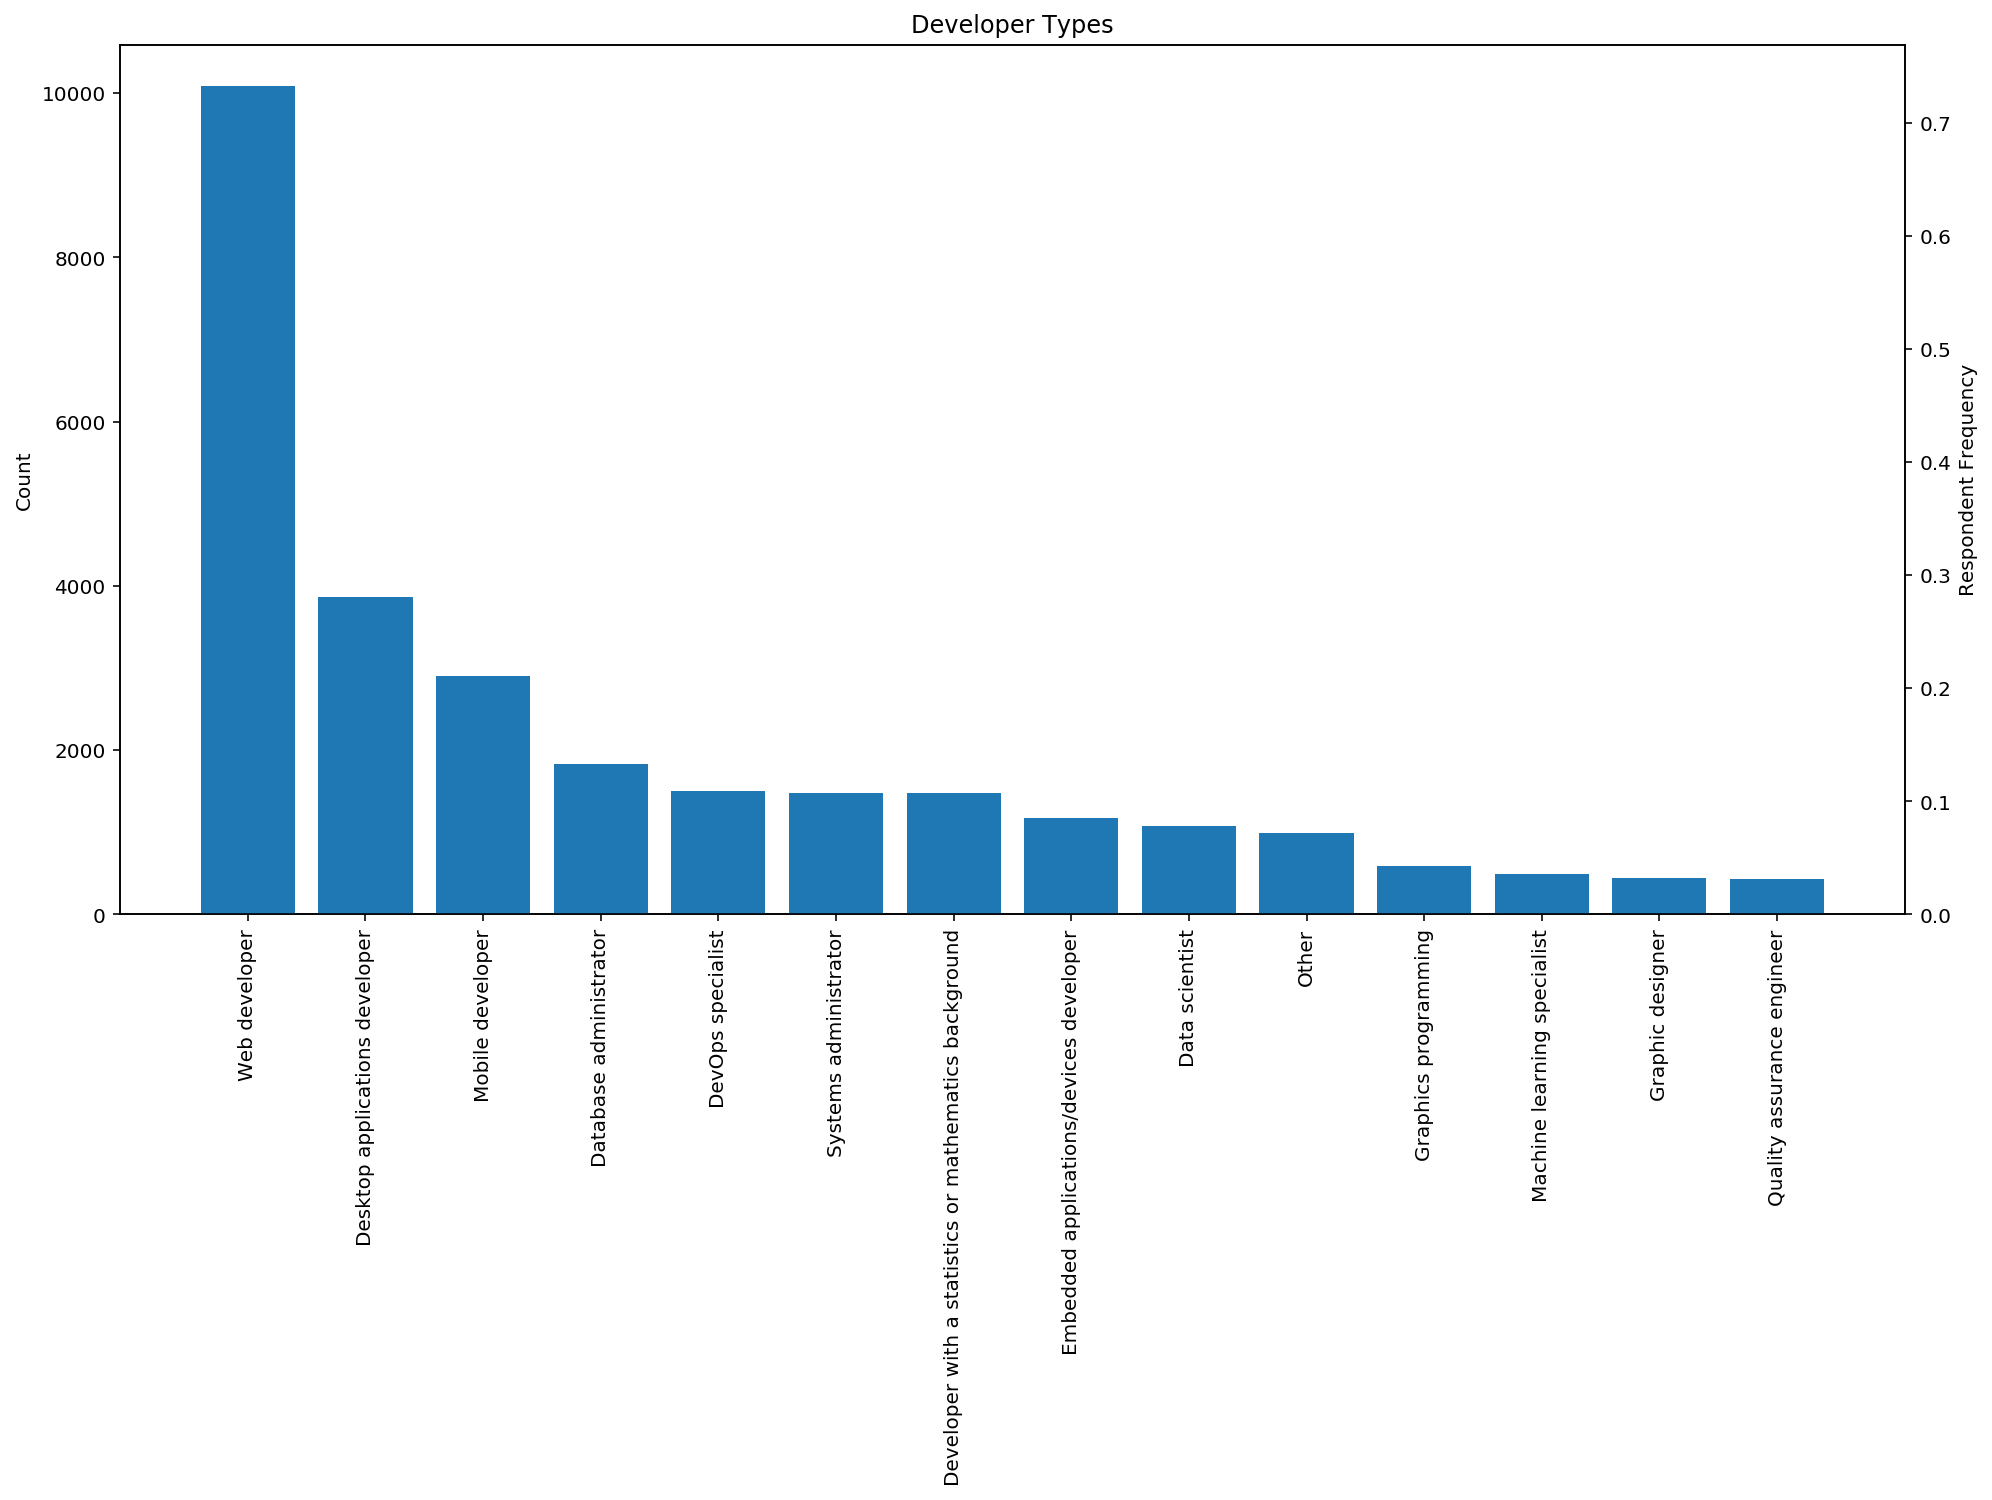

In [11]:
# Plot responses by developer type
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.bar(response_df_sorted.index,response_df_sorted['Count'])
ax2 = ax1.twinx()
ax2.bar(response_df_sorted.index,response_df_sorted['Respondent_Freq'])
ax1.set_xticklabels(response_df_sorted.index, rotation=90)
ax1.set_ylabel('Count')
ax2.set_ylabel('Respondent Frequency')
ax1.set_title('Developer Types')
plt.show()

In [12]:
num_responses = response_df_sorted['Count'].sum()
print('The number of respondents:',num_respondents)
print('The number of responses:',num_responses)
print('The average number of responses per respondent: {:.2f}'.format(num_responses/num_respondents))

The number of respondents: 13771
The number of responses: 28337
The average number of responses per respondent: 2.06


The most common response was 'Web developer' with over 10,000 responses, making up over 70% of respondents.  Data scientists made up 1077 responses (7.8% of respondents) and 'Machine learning specialists' were included in 488 responses (3.5%).  I will need to be careful when comparing the mean salary and job satisfaction for Web developers to those of data scientists and machine learning specialists since they have vastly different sample sizes.  Outliers could heavily skew the results of the developer types with small sample sizes.  Furthermore, the fact that respondents were allowed to select multiple developer types, with the average number of developer types per respondent being 2, means it is going to be difficult to isolate the effect that being a data scientist or machine learning specialist has on salary and job satisfaction.

This initial breakdown of the developer types counted each type in isolation.  Next, I need to identify which developer type(s) each respondent selected.  I will perform onehot encoding, creating 14 new columns in the dataframe to capture whether each respondent selected a particular developer type.  Pandas has a very convenient function called *get_dummies* for this process, but it will not work on the 'DeveloperType' column because it has multiple responses in a given row and the function assumes one response per row.

In [13]:
# Write a function to loop through every row and assign 1's to the developer type columns included in 'DeveloperType'
def generate_onehot(df,column,separator):
    '''
    Loops through the dataframe (df) and onehot encodes the column
    This function is intended for onehot encoding a column that has multiple entries in a single column that need to be parsed
    Drops the original column
    
    df: pandas Dataframe
    column: string, the column in df to be encoded
    separator: string, the separator between multiple entries in a single row
    
    returns: df, pandas Dataframe with onehot encoded columns and without the original column
    '''
    # Copy the dataframe
    df_copy = df.copy()
    
    # Initialize the set of possible responses
    response_set = set()
    
    # Loop through the column
    for response in df_copy[column]:
        # Split the response by the separator into multiple entries
        entries = str(response).split(separator)
        # For each entry in the response, add it to the set of responses
        for entry in entries:
            response_set.add(entry)
    
    # Add new columns for the responses with all rows containing 0
    for new_column in list(response_set):
        df_copy[new_column] = 0
    
    # Loop through the rows of the dataframe
    for row in range(len(df_copy)):
        # Split the response by the separator into multiple entries
        entries = str(df_copy.loc[row,column]).split(separator)
        # Set the value in the new column equal to 1
        for entry in entries:
            df_copy.loc[row,entry] = 1
    
    # Drop the original column
    df_copy.drop(columns=column, inplace=True)
    
    return df_copy

In [21]:
# Call the generate_onehot function on the original dataset
original_df = pd.read_csv('survey_results_public.csv')
encoded_df = generate_onehot(original_df,'DeveloperType','; ')

In [22]:
# View the first 10 rows of the encoded dataframe to verify onehot encoding
encoded_df.head(10)

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,DevOps specialist,Machine learning specialist,nan,Mobile developer,Other,Graphics programming,Database administrator,Desktop applications developer,Graphic designer,Developer with a statistics or mathematics background
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,0,0,1,0,0,0,0,0,0,0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,0,0,0,0,1,0,0,0,0,0
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,0,0,1,0,0,0,0,0,0,0
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,0,0,0,1,0,1,0,1,0,0
5,6,Student,"Yes, both",New Zealand,"Yes, full-time","Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
6,7,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Master's degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...",20 to 99 employees,...,0,0,1,0,0,0,0,0,0,0
7,8,Professional developer,"Yes, both",Poland,No,Employed full-time,Master's degree,Computer science or software engineering,All or almost all the time (I'm full-time remote),Fewer than 10 employees,...,0,0,0,0,0,0,0,0,0,0
8,9,Professional developer,"Yes, I program as a hobby",Colombia,"Yes, part-time",Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","5,000 to 9,999 employees",...,0,0,0,1,0,0,0,0,0,0
9,10,Professional developer,"Yes, I program as a hobby",France,"Yes, full-time","Independent contractor, freelancer, or self-em...",Master's degree,Computer science or software engineering,It's complicated,NaN,...,0,0,0,1,0,0,0,1,0,0


In [30]:
# Drop the 'nan' column
encoded_df.drop(columns='nan', inplace=True)
# Add a row to calculate how many Developer Types each person provided
encoded_df['NumDevTypes'] = encoded_df.iloc[:,-14:].sum(axis=1)

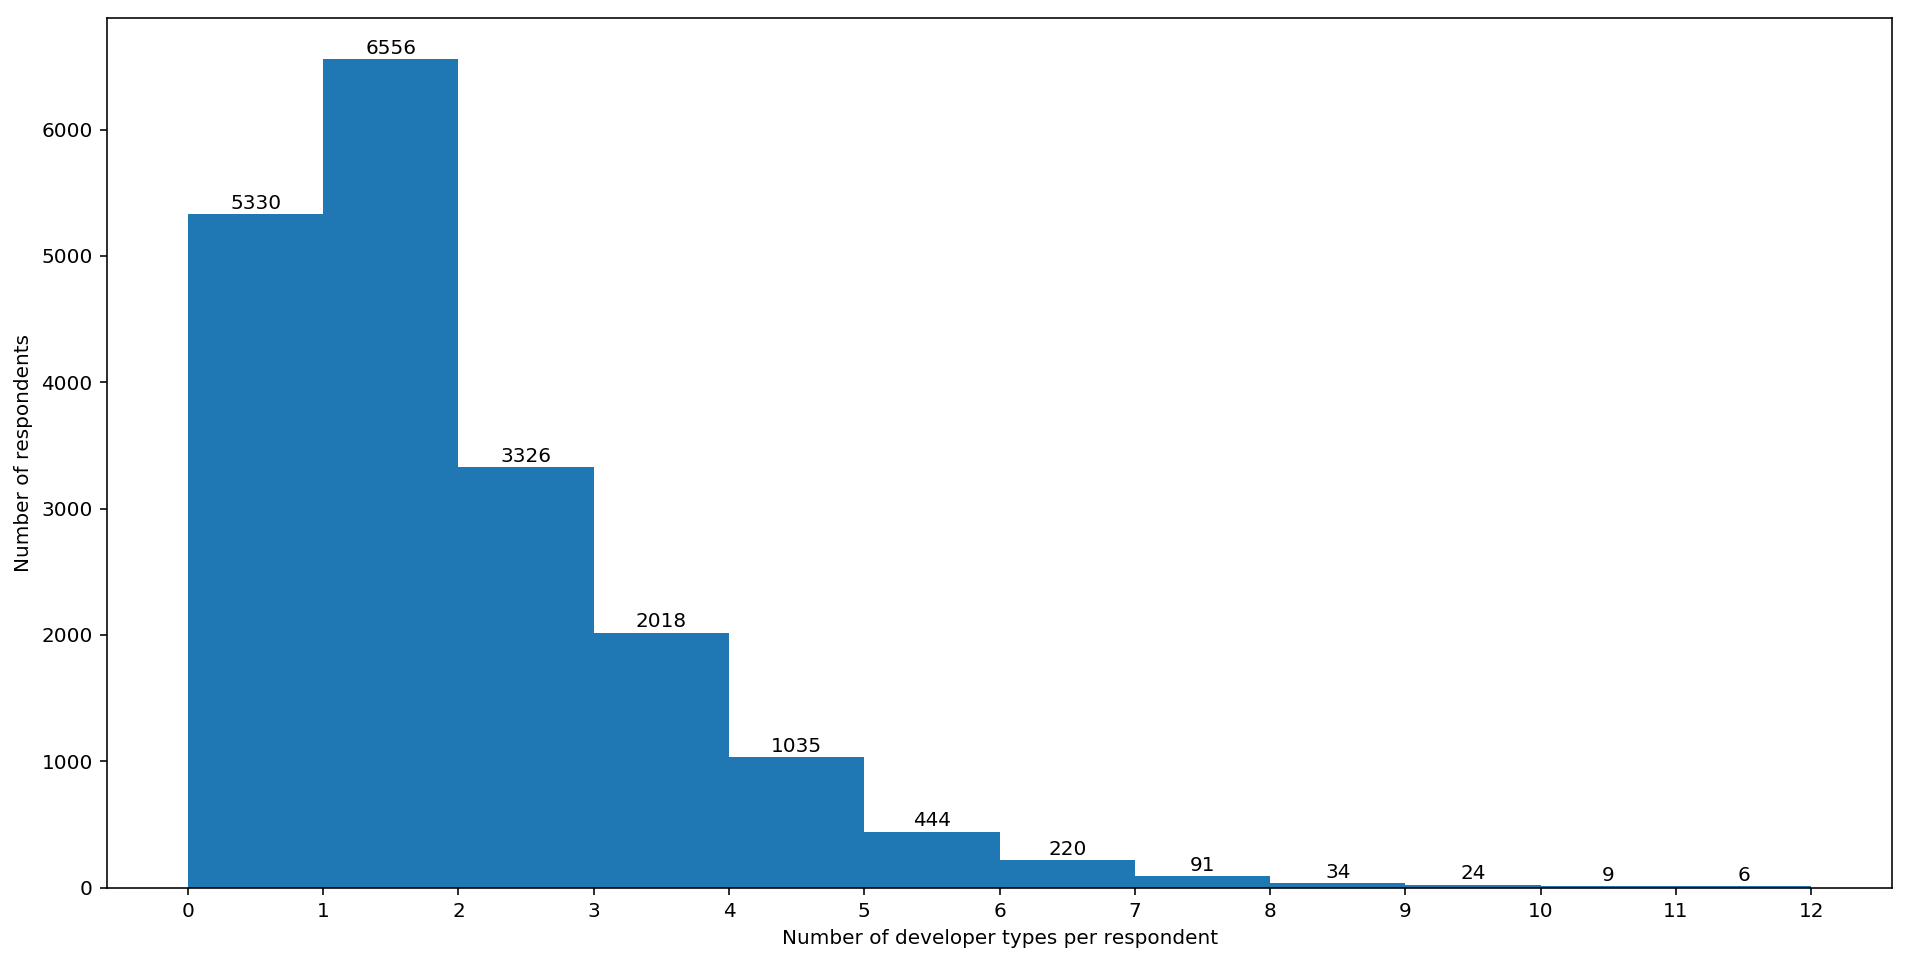

In [329]:
# Visualize the distribution of developer types
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(encoded_df['NumDevTypes'],bins=range(encoded_df['NumDevTypes'].max()))
ax.set_xticks(range(encoded_df['NumDevTypes'].max()))
ax.set_ylabel('Number of respondents')
ax.set_xlabel('Number of developer types per respondent')

# Add value counts to histogram bars
rects = ax.patches
labels = encoded_df['NumDevTypes'].value_counts(sort=False)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, label,
            ha='center', va='bottom')
plt.show()

Again we see the 5330 missing responses in the histogram.  The most common number of developer types for a respondent is 1 (6556 respondents) with decreasing counts as the number of developer types increases up to 11.

### Data Analysis
One way to compare the effect of data scientists and machine learning specialists on salary and job satisfaction is to split the respondents into those that included 'Data scientist' and/or 'Machine learning specialist' in their survey response to those that did not.

In [49]:
# Compare mean salaries of respondents who included 'Data scientist' to those who did not
encoded_df.groupby('Data scientist')['Salary'].mean()

Data scientist
0    57811.470365
1    65572.904236
Name: Salary, dtype: float64

In [50]:
# Compare mean job satisfactions of respondents who included 'Data scientist' to those who did not
encoded_df.groupby('Data scientist')['JobSatisfaction'].mean()

Data scientist
0    6.976594
1    7.335283
Name: JobSatisfaction, dtype: float64

In [54]:
# Compare mean salaries of respondents who included 'Data scientist' and/or 'Machine learning specialist' to those who did not
encoded_df.groupby(['Data scientist','Machine learning specialist'])['Salary'].mean()

Data scientist  Machine learning specialist
0               0                              57702.467161
                1                              66324.805294
1               0                              63595.815488
                1                              70789.053271
Name: Salary, dtype: float64

In [55]:
# Compare mean job satisfactions of respondents who included 'Data scientist' and/or 'Machine learning specialist' to those who did not
encoded_df.groupby(['Data scientist','Machine learning specialist'])['JobSatisfaction'].mean()

Data scientist  Machine learning specialist
0               0                              6.973240
                1                              7.244318
1               0                              7.279570
                1                              7.482270
Name: JobSatisfaction, dtype: float64

In [56]:
# Determine percentage of respondents who included 'Machine learning specialist' given they included 'Data scientist'
encoded_df.groupby('Data scientist')['Machine learning specialist'].mean()

Data scientist
0    0.010485
1    0.277623
Name: Machine learning specialist, dtype: float64

In [57]:
# Determine percentage of respondents who included 'Data scientist' given they included 'Machine learning specialist'
encoded_df.groupby('Machine learning specialist')['Data scientist'].mean()

Machine learning specialist
0    0.041796
1    0.612705
Name: Data scientist, dtype: float64

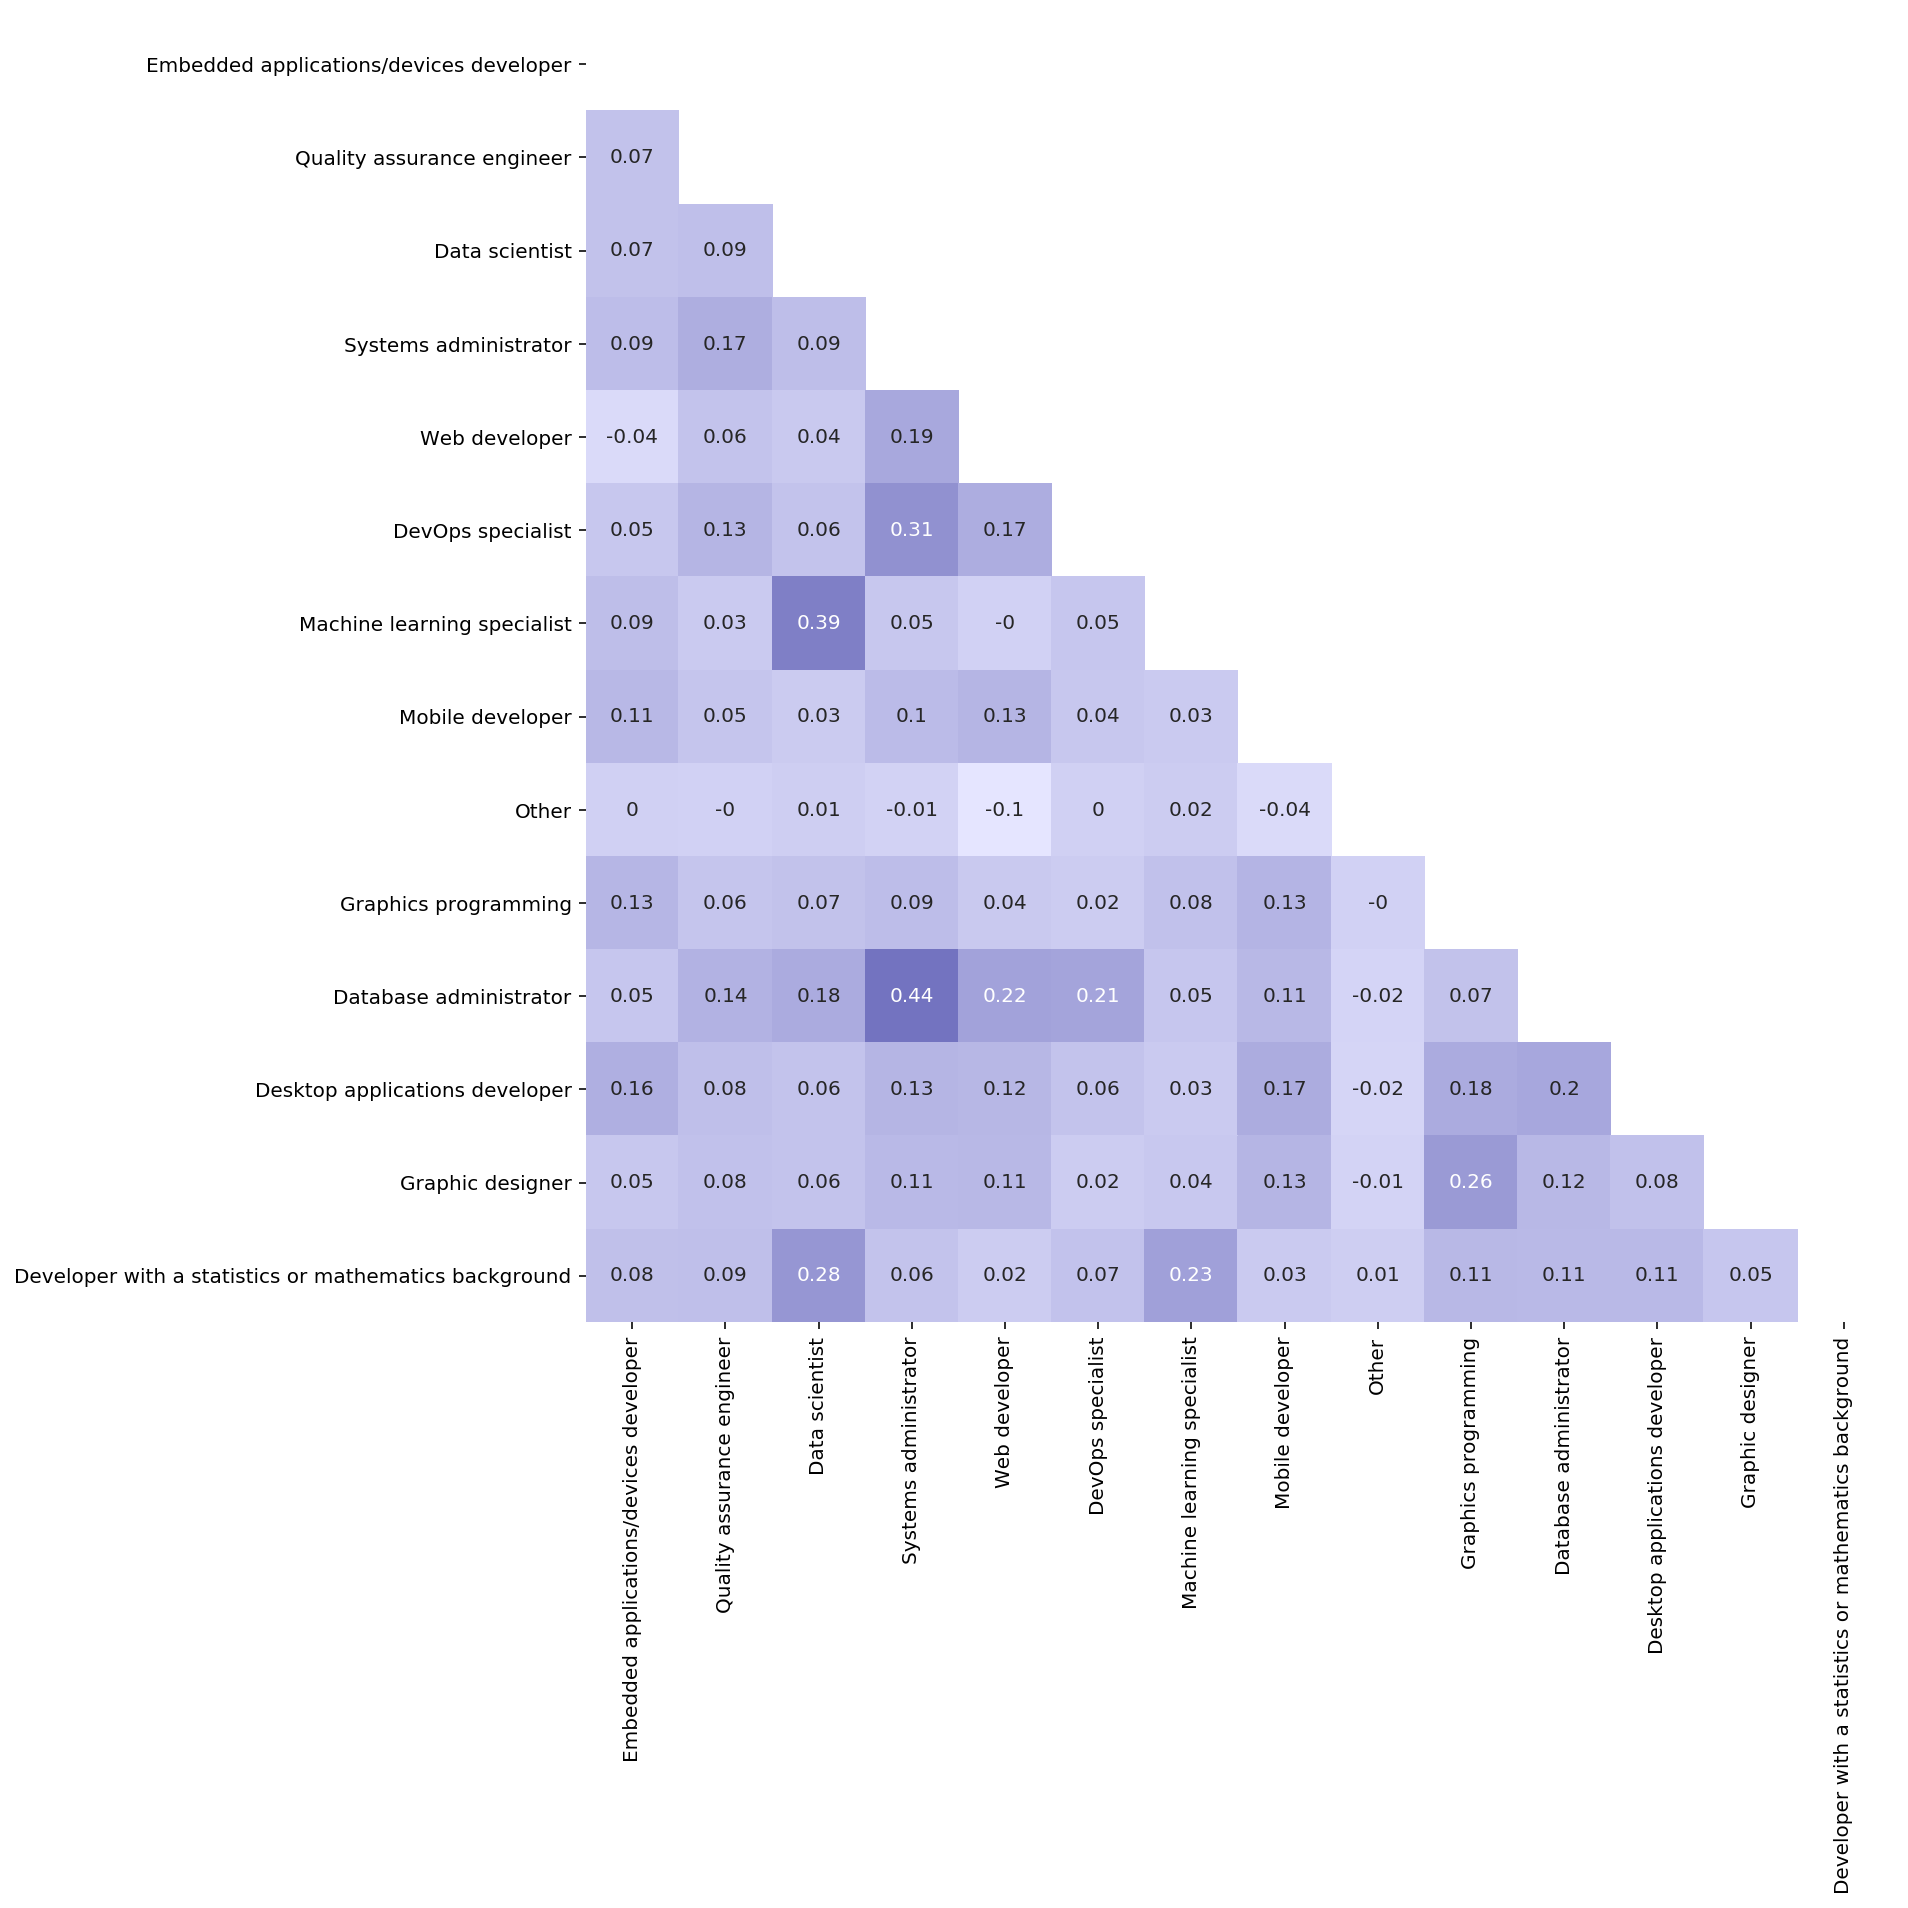

In [330]:
# Calculate correlations between the 14 DeveloperTypes
corr = encoded_df.iloc[:,-15:-1].corr()

# Visualize in a heat map
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.light_palette('navy',n_colors=5, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot=np.round(corr.values,2), square=True, cbar=False)

Performing some simple calculations on binary groupings (*i.e* data scientists vs not data scientists) gave me some good insights into how respondents answered this survey and I can begin to see the effect of data science and machine learning roles on salary and job satisfaction.<br>
<br>
**Results:**
- The mean salary for respondents who included 'Data scientist' was over **13% higher** (\\$65,572 vs \\$57,811) than those who did not.
- The mean job satisfaction for data scientists was **5% higher** (7.33 vs 6.97).
- Adding in 'Machine learning specialist' created even more separation in salary and job satisfaction:
    - Respondents who included both 'Data scientist' and 'Machine learning specialist' had a mean salary of **\\$70,789**, respondents who included one of the two had mean salaries between **\\$63,595-\\$66,324**, while respondents who did not include either had a mean salary of **\\$57,702**.
    - Respondents who included both 'Data scientist' and 'Machine learning specialist' had a mean job satisfaction rating of **7.48**, respondents who included one of the two had mean job satisfaction ratings between **7.24-7.28**, while respondents who did not include either had a mean job satisfaction rating of **6.97**.
- 27% of 'Data scientists' also included 'Machine learning specialist' in their response.
- 61% of 'Machine learning specialists' also included 'Data scientist' in their response.
- 'Data scientist' and 'Machine learning specialist' had the second highest correlation between any two developer types (1st was 'Database administrator' and 'Systems administrator').
  
**Takeaways:**
Respondents who are data scientists or machine learning specialists appear to have higher average salaries and job satisfaction ratings than other types of developers.  These two developer types are also closely related, as would be expected since a 'Machine learning specialist' can be considered a specialized type of data scientist.  

### Modeling

To really separate the effect of being a data scientist on salary and job satisfaction, I need to do more than just compare two different developer types.  Looking at the mean salary of data scientists and comparing it to the mean salary of those who are not data scientists does not account for all of the other potential developer types or other hidden variables.  For example, perhaps data scientists are more common in the United States, where salaries are higher; or machine learning specialists are considered senior developers, so their salaries are higher due to more years in the industry.  A better way to do this would be to create linear models to predict salary and job satisfaction and look at the feature weights to see which developer type has the biggest impact on each.  I will use scikit-learn's *LinearRegression* package to create these models.

In [159]:
# Create a new dataframe with only the features I am interested in - DeveloperType, Salary, and JobSatisfaction
model_df = original_df[['DeveloperType','Salary','JobSatisfaction']]

In [160]:
# Visualize first 5 rows
model_df.head()

,DeveloperType,Salary,JobSatisfaction
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Other,113750.0,9.0
3,NaN,NaN,3.0
4,Mobile developer; Graphics programming; Deskto...,NaN,8.0


I need to handle the 'NaN's in each of the three columns.  For the 'DeveloperType' column, this is my input column into a model.  I could drop the rows with 'NaN' or keep them and impute a value into those rows.  Before deciding, I am curious whether there are Salary and Job satisfaction values reported by respondents who didn't answer the developer type question.

In [169]:
# Generate the onehot encoded dataframe for 'DeveloperType'
encoded_model_df = generate_onehot(model_df,'DeveloperType','; ')

In [170]:
# Look at descriptive stats for Salary and Job Satisfaction for missing values for 'DeveloperType'
encoded_model_df.loc[encoded_model_df['nan']==1][['Salary','JobSatisfaction']].describe()

,Salary,JobSatisfaction
count,1.0,1892.000000
mean,125000.0,6.661734
std,NaN,2.304149
min,125000.0,0.000000
25%,125000.0,5.000000
50%,125000.0,7.000000
75%,125000.0,8.000000
max,125000.0,10.000000


In [163]:
# Look at descriptive statistics for Salary and Job Satisfaction for Web developers for comparison
encoded_model_df.loc[encoded_model_df['Web developer']==1][['Salary','JobSatisfaction']].describe()

,Salary,JobSatisfaction
count,3669.000000,9813.000000
mean,56814.961123,7.040151
std,39866.740326,2.079548
min,0.000000,0.000000
25%,26881.720430,6.000000
50%,50000.000000,7.000000
75%,80645.161290,8.000000
max,195000.000000,10.000000


There appears to be one respondent who provided a (rather high) salary without reporting a developer type.  I would be comfortable dropping this one data point from the model for predicting salary.  However, of the 5330 respondents who did not answer the developer type question, 1892 of them did provide a job satisfaction rating.  I want keep these rows so as not to ignore these data.  I will assign all respondents who did not answer the 'DeveloperType' question to 'Web developer' since they made up 70% of the respondents and also have a similar distribution of Job satisfaction ratings as those with missing developer types.

In [171]:
# Fill 'NaN's in 'DevloperType' with 'Web developer'
model_df.fillna({'DeveloperType':'Web developer'},inplace=True)

In [172]:
# Visualize first 5 rows of dataframe.  There should not be 'NaN' values in 'DeveloperType'
model_df.head()

,DeveloperType,Salary,JobSatisfaction
0,Web developer,NaN,NaN
1,Web developer,NaN,NaN
2,Other,113750.0,9.0
3,Web developer,NaN,3.0
4,Mobile developer; Graphics programming; Deskto...,NaN,8.0


In [173]:
# Regenerate the onehot encoded df, this time without NaN values in the 'DeveloperType' column
encoded_model_df = generate_onehot(model_df,'DeveloperType','; ')

In [174]:
# Split the dataset for the two models
salary_df = encoded_model_df.drop(columns='JobSatisfaction')
jobsat_df = encoded_model_df.drop(columns='Salary')

In [177]:
# Drop missing values from the response variables 'Salary' and 'JobSatisfaction'
salary_df.dropna(inplace=True)
jobsat_df.dropna(inplace=True)

In [231]:
# Write a function to split the dataset into X and y, train and test, instantiate, fit, predict, and score a Linear Regression model
def generate_model(df, output, test_size = 0.3, rand_state = 42):
    '''
    Generate a linear regression model by specifying a dataset and the output column
    
    df: pandas DataFrame, should be cleaned already and include the output column
    output: string, the name of the column in df that is the output variable
    test_size: float (default=0.3), the fraction of the dataset, df, that is dedicated to testing
    rand_state: int (default=42), the random state number for reproducible results
    
    returns:
    X_train, X_test, y_train, y_test, model, train_score, test_score
    '''
    # Split the dataset, df, into X (input matrix) and y (response vector)
    X = df.drop(columns=output)
    y = df[output]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state, shuffle=True)
    
    # Instantiate linear regression model
    model = LinearRegression(normalize=False) # Note, since X is onehot encoded, I will not normalize
    
    # Fit model to train data
    model.fit(X_train, y_train)
    
    # Predict training and testing values
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    # Score the training and testing sets
    train_score = r2_score(y_train, y_train_preds)
    test_score = r2_score(y_test, y_test_preds)
    
    return X_train, X_test, y_train, y_test, model, train_score, test_score

In [331]:
# Call generate_model function on the salary data
X_train_sal, X_test_sal, y_train_sal, y_test_sal, model_sal, train_score_sal, test_score_sal = generate_model(salary_df, 'Salary')

print('Training score on salary model:',train_score_sal)
print('Testing score on salary model:',test_score_sal)

Training score on salary model: 0.03634599232117963
Testing score on salary model: 0.0314390963484692


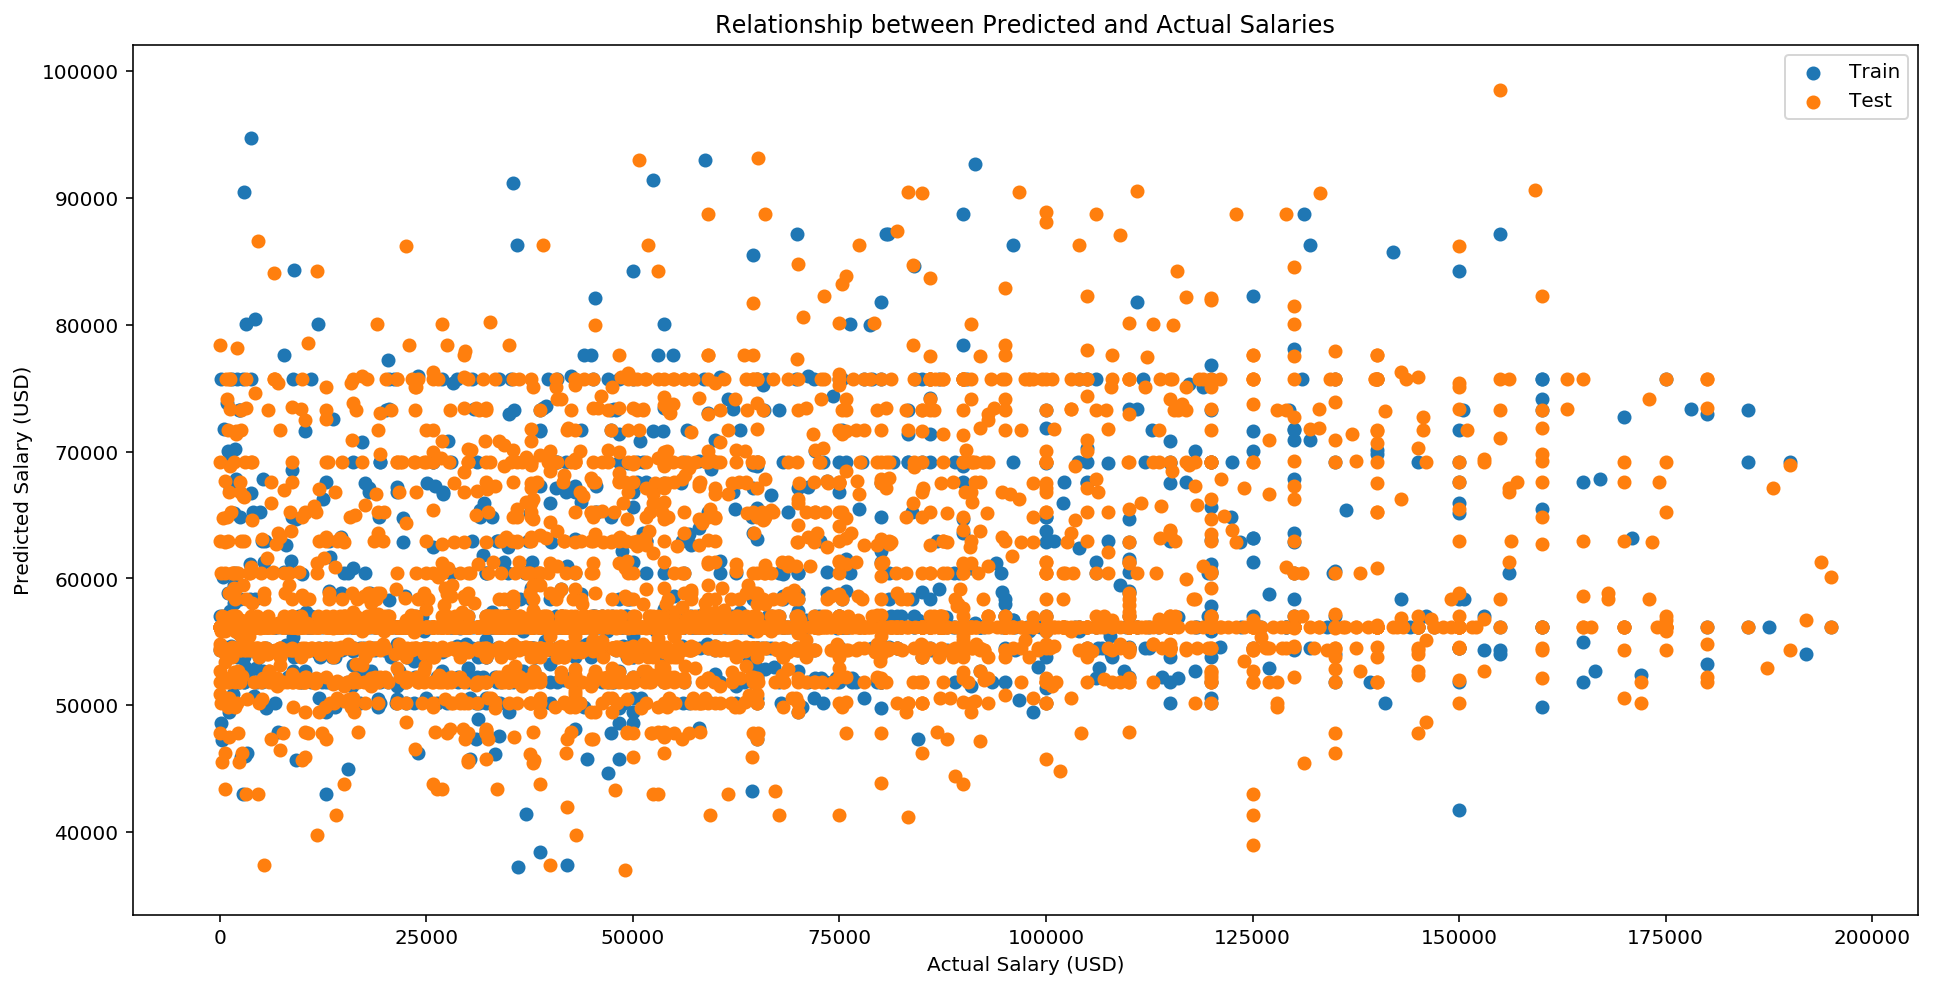

In [335]:
# Visualize the relationship between predicted and actual salaries for the test and training sets
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y_test_sal, model_sal.predict(X_test_sal))
ax.scatter(y_train_sal, model_sal.predict(X_train_sal))
ax.legend(['Train','Test'])
ax.set_xlabel('Actual Salary (USD)')
ax.set_ylabel('Predicted Salary (USD)')
ax.set_title('Relationship between Predicted and Actual Salaries')
plt.show()

In [332]:
# Call generate_model function on the job satisfaction data
X_train_job, X_test_job, y_train_job, y_test_job, model_job, train_score_job, test_score_job = generate_model(jobsat_df, 'JobSatisfaction')

print('Training score on job satisfaction model:',train_score_job)
print('Testing score on job satisfaction model:',test_score_job)

Training score on job satisfaction model: 0.0064705477639624975
Testing score on job satisfaction model: 0.0028418488226263916


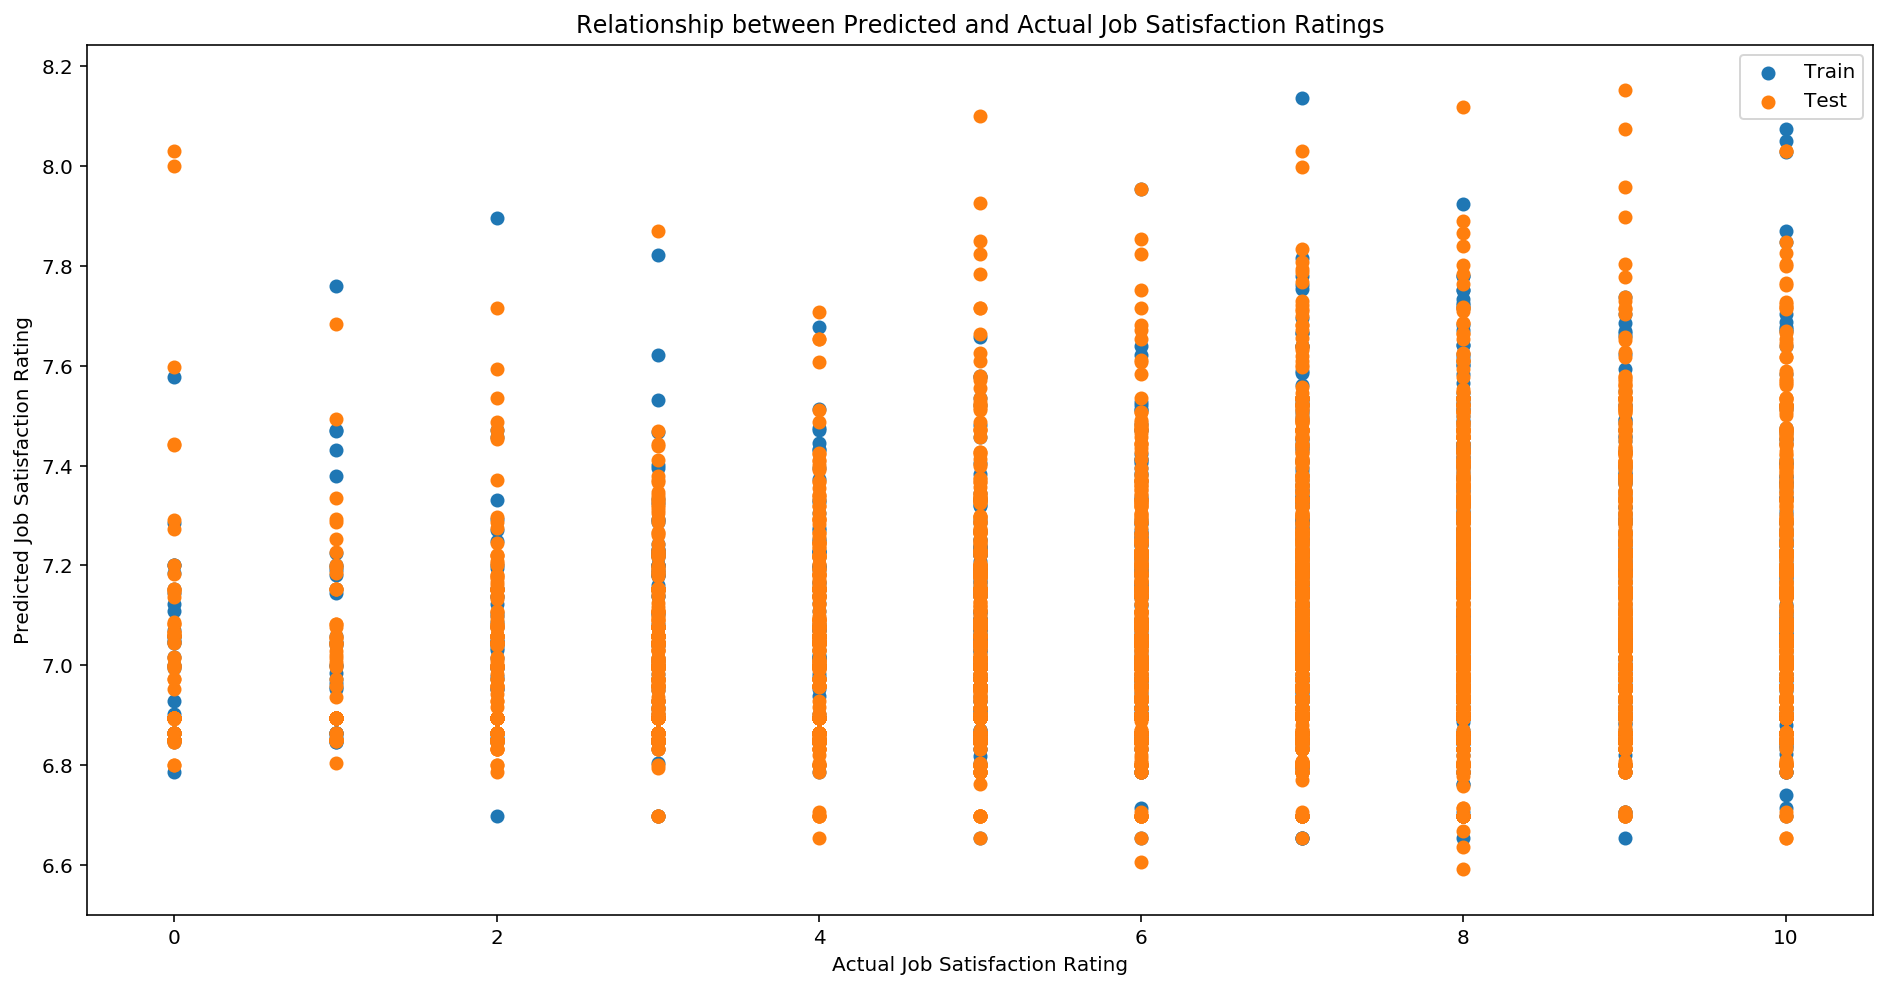

In [336]:
# Visualize the relationship between predicted and actual job satisfaction ratings for the test and training sets
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y_test_job, model_job.predict(X_test_job))
ax.scatter(y_train_job, model_job.predict(X_train_job))
ax.legend(['Train','Test'])
ax.set_xlabel('Actual Job Satisfaction Rating')
ax.set_ylabel('Predicted Job Satisfaction Rating')
ax.set_title('Relationship between Predicted and Actual Job Satisfaction Ratings')
plt.show()

Neither the salary nor the job satisfaction model had very high $r^2$ values for either the training or testing data sets.  Looking at the job satisfaction scatter plot specifically, the predicted ratings only ranged from 6.6 to 8.2 whereas the actual ratings ranged from 0 to 10.  These scores tell me that developer type by itself is not a strong enough feature to predict salary or job satisfaction.  Thinking back to a previous study that I performed on the Stack Overflow survey data for a class, 'Country' and 'YearsCodedJob' were the two features most strongly related to salary.  I will build new models with these additional features and see if I can obtain better fits.  Once I have models that perform reasonably well I can look at the contributions that the developer types have on the salary and job satisfaction predictions.

In [349]:
# Create a new dataframe with 'Country' and 'YearsCodedJob' features in added
model2_df = original_df[['Country','YearsCodedJob','DeveloperType','Salary','JobSatisfaction']]

In [350]:
# Check the number of null values in each feature
model2_df.isnull().sum(axis=0)

Country                0
YearsCodedJob       3711
DeveloperType       5330
Salary             14093
JobSatisfaction     3849
dtype: int64

There are no missing values in the 'Country' feature but there are 3711 in the 'YearsCodedJob' feature.  Since this feature is categorical, I will fill the missing values with the most common value (mode).  For 'DeveloperType', I will perform the same imputation as before and replace missing values with 'Web developer'.

In [351]:
# Fill missing values in 'DeveloperType' with 'Web developer' and in 'YearsCodedJob' with the mode
model2_df = model2_df.fillna({'DeveloperType':'Web developer', 'YearsCodedJob':model2_df['YearsCodedJob'].mode()[0]})

In [352]:
# Check that missing values have been removed from the input features
model2_df.isnull().sum(axis=0)

Country                0
YearsCodedJob          0
DeveloperType          0
Salary             14093
JobSatisfaction     3849
dtype: int64

In [353]:
# Split the dataset for the two models
salary2_df = model2_df.drop(columns='JobSatisfaction')
jobsat2_df = model2_df.drop(columns='Salary')

In [354]:
# Drop missing values from the response variables 'Salary' and 'JobSatisfaction'
salary2_df.dropna(inplace=True)
jobsat2_df.dropna(inplace=True)

In [358]:
# Perform onehot encoding on the 'Country' and 'YearsCodedJob' categorical features
encoded_salary2_df = pd.get_dummies(salary2_df,columns=['Country','YearsCodedJob'])

# Reset the indices after splitting (necessary for the generate_onehot function below)
encoded_salary2_df.reset_index(inplace=True, drop=True)
encoded_salary2_df.head()

,DeveloperType,Salary,Country_Afghanistan,Country_Albania,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaidjan,Country_Bangladesh,...,YearsCodedJob_2 to 3 years,YearsCodedJob_20 or more years,YearsCodedJob_3 to 4 years,YearsCodedJob_4 to 5 years,YearsCodedJob_5 to 6 years,YearsCodedJob_6 to 7 years,YearsCodedJob_7 to 8 years,YearsCodedJob_8 to 9 years,YearsCodedJob_9 to 10 years,YearsCodedJob_Less than a year
0,Other,113750.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Embedded applications/devices developer,100000.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Web developer; Embedded applications/devices d...,130000.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Web developer,82500.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Other,100764.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [359]:
# Regenerate the onehot encoded df, this time without NaN values in the 'DeveloperType' column
encoded_salary2_df = generate_onehot(encoded_salary2_df,'DeveloperType','; ')

# Check shape of dataframe prior to modeling
encoded_salary2_df.shape

(5009, 143)

There are only 5009 rows in the dataset due to the large number of missing salaries from the survey results.  Meanwhile, there are 143 features in the dataset due to the onehot encoding of the categorical features.  I am guessing that most of these features are countries and that not all of them are necessary for the model.  I will check what the mean value of each feature is to see the frequency of occurence in the dataset.

In [360]:
# Calculate mean of each feature and sort from highest to lowest
encoded_salary2_df.mean(axis=0).sort_values(ascending=False)

Salary                                                   58341.398571
Web developer                                                0.732681
Country_United States                                        0.294071
Desktop applications developer                               0.276103
Mobile developer                                             0.195249
Database administrator                                       0.127770
DevOps specialist                                            0.119185
YearsCodedJob_2 to 3 years                                   0.113396
YearsCodedJob_1 to 2 years                                   0.107806
Systems administrator                                        0.103813
Developer with a statistics or mathematics background        0.103214
YearsCodedJob_3 to 4 years                                   0.097225
Country_United Kingdom                                       0.094430
YearsCodedJob_4 to 5 years                                   0.088042
YearsCodedJob_5 to 6

As I suspected, quite a few country features have very low frequencies in the dataset, with the lowest only occuring in 0.02% of rows.  In a dataset with 5009 rows, 0.02% means there is exactly 1 row in which a respondent selected that country.  These features will not help the model since they do not actually contain much information in them.  To determine how many of these low frequency features to drop, I will look at the frequencies of the 14 developer types and drop any columns with lower frequencies.

In [365]:
# Calculate mean of each of the 14 developer type features and sort from highest to lowest
encoded_salary2_df.iloc[:,-14:].mean(axis=0).sort_values(ascending=False)

Web developer                                            0.732681
Desktop applications developer                           0.276103
Mobile developer                                         0.195249
Database administrator                                   0.127770
DevOps specialist                                        0.119185
Systems administrator                                    0.103813
Developer with a statistics or mathematics background    0.103214
Embedded applications/devices developer                  0.080256
Other                                                    0.080056
Data scientist                                           0.068277
Graphics programming                                     0.035536
Quality assurance engineer                               0.032741
Machine learning specialist                              0.030545
Graphic designer                                         0.020763
dtype: float64

In [366]:
# Since the lowest frequency developer type feature is just above 2%, I will use a 2% cutoff and drop any features below that
reduced_salary_df = encoded_salary2_df[encoded_salary2_df.columns[encoded_salary2_df.mean(axis=0)>0.02]]

# Check shape after feature selection
reduced_salary_df.shape

(5009, 39)

By dropping features with very little information in them, I have reduced the dataset from 143 features to 39.  This is a more reasonable number to try to model with only 5009 rows.

In [368]:
# Call the generate_model function on the salary dataset
X_train2_sal, X_test2_sal, y_train2_sal, y_test2_sal, model2_sal, train_score2_sal, test_score2_sal = generate_model(reduced_salary_df, 'Salary')

print('Training score on salary model with Country and YearsCoded:',train_score2_sal)
print('Testing score on salary model with Country and YearsCoded:',test_score2_sal)

Training score on salary model with Country and YearsCoded: 0.6233990632870385
Testing score on salary model with Country and YearsCoded: 0.6150584958440461


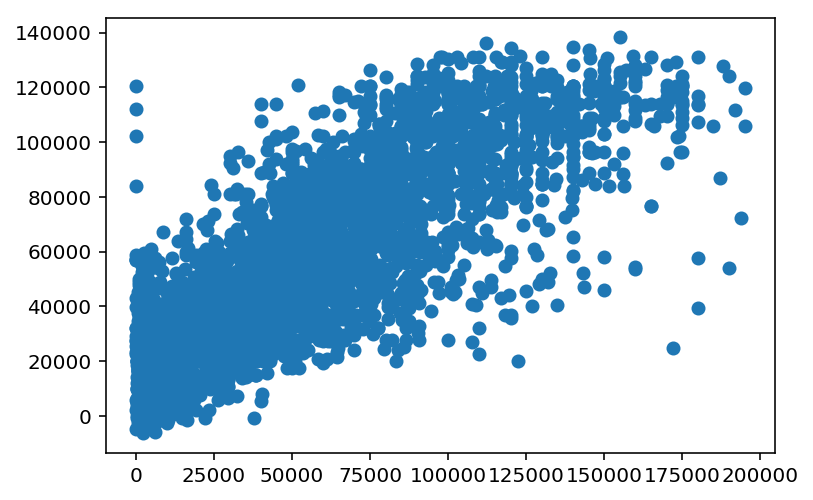

In [320]:
plt.scatter(y_train2_sal, model2_sal.predict(X_train2_sal))

In [321]:
r2_score(y_train2_sal, model2_sal.predict(X_train2_sal))

0.6233990632870385

In [322]:
r2_score(y_test2_sal, model2_sal.predict(X_test2_sal))

0.6150584958440461

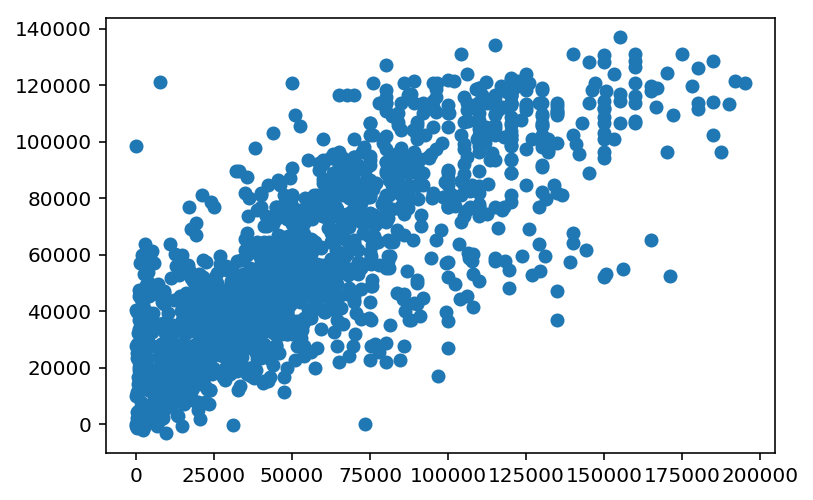

In [323]:
plt.scatter(y_test2_sal, model2_sal.predict(X_test2_sal))

In [324]:
sal2_weights = pd.DataFrame()
sal2_weights['Input'] = X_test2_sal.columns
sal2_weights['Weight'] = model2_sal.coef_

In [325]:
sal2_weights.iloc[-14:,:].sort_values('Weight',ascending=False)

,Input,Weight
30,Machine learning specialist,10648.084683
32,Other,7939.707977
29,DevOps specialist,7478.227342
26,Data scientist,2850.665569
37,Developer with a statistics or mathematics bac...,1927.820809
31,Mobile developer,816.885580
33,Graphics programming,406.629337
27,Systems administrator,-1770.489698
25,Quality assurance engineer,-2176.426467
28,Web developer,-2560.915525
